# Support.py in Notebook

In [1]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


# Code 

In [2]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
import copy
from tqdm.auto import tqdm

In [3]:
data = load_dataset("dataset_a1.txt")

## Q1

In [4]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 50        # Number of Generations
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) # Uses fitness function from support to evaluate fitness
toolbox.register("mate", tools.cxTwoPoint) 
# toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB) # indpb is the probability of flipping each bit in the individual
# uniform integer mutation: each gene is reset to U(low,up) with probability indpb
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB) # low and up are the bounds for the mutation, indpb is the probability of mutation for each gene
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  # tournsize is the number of individuals to select for the tournament, fittest is selected for next gen

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	max	avg     	min	std    
0  	100   	-3 	-9.60371	-19	3.44705
1  	46    	-2.91008	-6.92835	-13	2.57708
2  	65    	-0.843825	-4.75802	-9 	1.64476
3  	63    	0.296424 	-3.50288	-7 	1.26035
4  	71    	0.296424 	-2.49431	-7 	1.32792
5  	62    	0.327051 	-1.58253	-4.65308	1.0658 
6  	66    	0.498903 	-0.93583	-5.66653	0.984944
7  	69    	0.411673 	-0.422333	-2.71429	0.733765
8  	56    	0.411673 	0.054204 	-1.77353	0.455623
9  	62    	0.411673 	0.160911 	-1.68362	0.414049
10 	53    	0.5397   	0.183429 	-2      	0.500628
11 	57    	0.5397   	0.168945 	-1.68292	0.48301 
12 	65    	0.559041 	0.242321 	-1.75391	0.402814
13 	65    	0.559041 	0.254688 	-1.84383	0.44118 
14 	50    	0.559041 	0.258266 	-3.79887	0.669104
15 	57    	0.559041 	0.375284 	-2.49311	0.433459
16 	52    	0.559041 	0.405558 	-1.79887	0.43194 
17 	64    	0.559041 	0.455893 	-2.54164	0.416505
18 	55    	0.625093 	0.351936 	-2.58218	0.617996
19 	63    	0.625093 	0.402983 	-3.77606	0.61313 
20 	62    	0.625093 	0.39007 

In [5]:
best_ind = hof[0]
print("\nBest Individual:")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)


Best Individual:
[1, 3, 2, 7, 0, 1, 3, 7, 5, 6, 4, 8, 7, 8, 5, 8, 7, 8, 0, 3, 4, 5, 3, 4]
Fitness: 0.6542485847485843


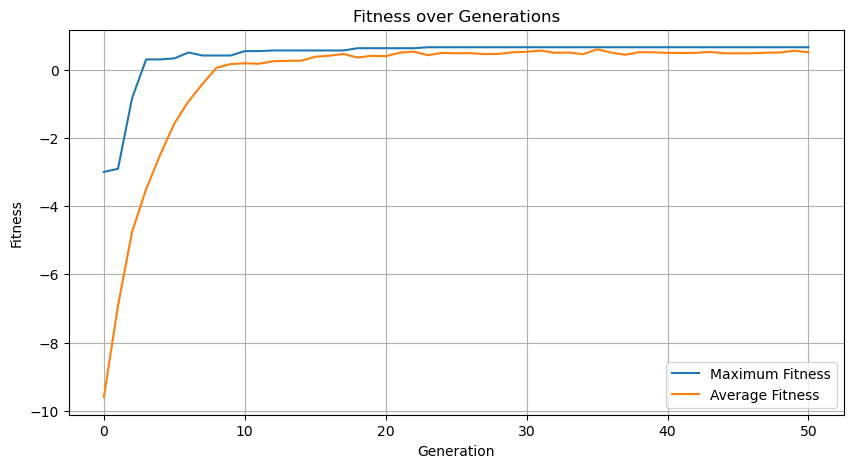

In [6]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
len(max_fitness)

51

In [8]:
# Visualize the best Petri net found
output_filename = "best_petri_net.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to best_petri_net.pdf


In [9]:
del creator.FitnessMax
del creator.Individual

# Q2

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox() # Create new empty toolbox

NGEN = 50        # Number of Generations
NUM_RUNS = 10    # Number of runs for boxplots  
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)

crossover_list = [tools.cxTwoPoint, tools.cxOrdered]
# mutation_list = [tools.mutFlipBit, tools.mutShuffleIndexes]
mutation_list = [tools.mutUniformInt, tools.mutShuffleIndexes]
selection_list = [tools.selTournament, tools.selRoulette]

combinations = list(itertools.product(crossover_list, mutation_list, selection_list))

In [11]:
def register_specified_variant(toolbox, Crossover, Mutation, Selection):
    toolbox.register("mate", Crossover) 
    # toolbox.register("mutate", Mutation, indpb=INDPB) 
    if Mutation is tools.mutUniformInt:
        # uniform‐int needs (low, up, indpb)
        toolbox.register(
            "mutate",
            tools.mutUniformInt,
            low=0,               # minimum allele value
            up=NR_PLACES - 1,    # maximum allele value
            indpb=INDPB          # per‐gene mutation probability
        )
    else:
        # flip‐bit and shuffle both just take indpb
        toolbox.register("mutate", Mutation, indpb=INDPB)

    if Selection == tools.selTournament:
        toolbox.register("select", Selection, tournsize=TOURNSIZE) # Try selTournament args, then selRoulette args
    else:
        toolbox.register("select", Selection)
    return toolbox

def run_genetic_algorithm_q2(toolbox, num_runs=NUM_RUNS):
    max_fitnesses_all_runs = []

    for run in tqdm(range(num_runs), desc="GA Runs", leave=True):

        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                           stats=stats, halloffame=hof, verbose=False)
        
        max_fitness = logbook.select("max")
        max_fitnesses_all_runs.append(max_fitness)

    max_fitnesses_all_runs = np.array(max_fitnesses_all_runs).T

    return max_fitnesses_all_runs

def plot_boxplot(max_fitnesses_all_runs, title):
    final_max_fitnesses = max_fitnesses_all_runs[-1, :]

    plt.figure(figsize=(8, 6))
    plt.boxplot(final_max_fitnesses, patch_artist=True) 
    plt.xlabel("Operator Combination")
    plt.ylabel("Final Maximum Fitness")
    plt.title(title)
    plt.xticks([1], ['']) 
    plt.grid(True, axis='y') 
    plt.show()

def plot_ABF(max_fitnesses_all_runs, title):
    abf = np.mean(max_fitnesses_all_runs, axis=1)
    generations = range(len(abf))

    plt.figure(figsize=(10, 5))
    plt.plot(generations, abf, label="Average Best Fitness (ABF)")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
results = {}

for i, comb in enumerate(tqdm(combinations, desc="Evaluating combinations")):
    tbx = base.Toolbox()
    tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))

    tbx = register_specified_variant(tbx, comb[0], comb[1], comb[2])

    print(f"Running combination {i+1}/{len(combinations)}: {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}")
    max_fitnesses_all_runs = run_genetic_algorithm_q2(tbx)
    results[i] = max_fitnesses_all_runs

Evaluating combinations:   0%|          | 0/8 [00:00<?, ?it/s]

Running combination 1/8: cxTwoPoint, mutUniformInt, selTournament


Evaluating combinations:  12%|█▎        | 1/8 [12:45<1:29:18, 765.50s/it]

Running combination 2/8: cxTwoPoint, mutUniformInt, selRoulette


Evaluating combinations:  25%|██▌       | 2/8 [41:28<2:12:50, 1328.49s/it]

Running combination 3/8: cxTwoPoint, mutShuffleIndexes, selTournament


Evaluating combinations:  38%|███▊      | 3/8 [53:31<1:27:41, 1052.34s/it]

Running combination 4/8: cxTwoPoint, mutShuffleIndexes, selRoulette


Evaluating combinations:  50%|█████     | 4/8 [1:05:48<1:01:51, 927.89s/it]

Running combination 5/8: cxOrdered, mutUniformInt, selTournament


Evaluating combinations:  62%|██████▎   | 5/8 [1:17:21<42:08, 842.87s/it]  

Running combination 6/8: cxOrdered, mutUniformInt, selRoulette


Evaluating combinations:  75%|███████▌  | 6/8 [1:29:58<27:07, 813.86s/it]

Running combination 7/8: cxOrdered, mutShuffleIndexes, selTournament


Evaluating combinations:  88%|████████▊ | 7/8 [1:42:15<13:08, 788.86s/it]

Running combination 8/8: cxOrdered, mutShuffleIndexes, selRoulette


Evaluating combinations: 100%|██████████| 8/8 [1:56:13<00:00, 871.66s/it]


In [13]:
# # Plot boxplots for each combination of crossover, mutation, and selection
# for i, comb in enumerate(combinations):
#     title = f"Distribution of Final Max Fitness for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
#     plot_boxplot(results[i], title)

# # Plot ABF for each combination of crossover, mutation, and selection
# for i, comb in enumerate(combinations):
#     title = f"Average Best Fitness (ABF) for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
#     plot_ABF(results[i], title)

import pandas as pd

# Build a record of just the ABF per combo
records = []
for i, (cx_op, mut_op, sel_op) in enumerate(combinations):
    arr       = results[i]          # shape = (n_gens, n_runs)
    abf_final = arr[-1, :].mean()   # mean of the last‐generation max fitnesses

    records.append({
        'Crossover': cx_op.__name__,
        'Mutation' : mut_op.__name__,
        'Selection': sel_op.__name__,
        'ABF'      : round(abf_final, 4)
    })

# Turn into a DataFrame and print
df_abf = pd.DataFrame(records,
                      columns=['Crossover','Mutation','Selection','ABF'])
print(df_abf)


    Crossover           Mutation      Selection     ABF
0  cxTwoPoint      mutUniformInt  selTournament  0.6960
1  cxTwoPoint      mutUniformInt    selRoulette  0.6346
2  cxTwoPoint  mutShuffleIndexes  selTournament  0.6916
3  cxTwoPoint  mutShuffleIndexes    selRoulette  0.5921
4   cxOrdered      mutUniformInt  selTournament  0.6232
5   cxOrdered      mutUniformInt    selRoulette  0.6220
6   cxOrdered  mutShuffleIndexes  selTournament  0.6835
7   cxOrdered  mutShuffleIndexes    selRoulette  0.5869


In [14]:
def plot_boxplot(results, combinations, title):
    all_final_max_fitnesses = []
    labels = []
    for i, comb in enumerate(combinations):
        max_fitnesses_all_runs = results[i]
        final_max_fitnesses = max_fitnesses_all_runs[-1, :]
        all_final_max_fitnesses.append(final_max_fitnesses)
        labels.append(f"{comb[0].__name__}\n{comb[1].__name__}\n{comb[2].__name__}") 

    plt.figure(figsize=(15, 8)) 
    plt.boxplot(all_final_max_fitnesses, labels=labels, patch_artist=True)
    plt.xlabel("Operator Combination (Crossover, Mutation, Selection)")
    plt.ylabel("Final Maximum Fitness")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout() 
    plt.show()

def plot_ABF(results, combinations, title):
    plt.figure(figsize=(12, 6)) 
    generations = None 

    for i, comb in enumerate(combinations):
        max_fitnesses_all_runs = results[i]
        abf = np.mean(max_fitnesses_all_runs, axis=1)
        if generations is None:
             generations = range(len(abf)) 
        label = f"{comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
        plt.plot(generations, abf, label=label)

    plt.xlabel("Generation")
    plt.ylabel("Average Best Fitness (ABF)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.grid(True)
    plt.tight_layout() 
    plt.show()

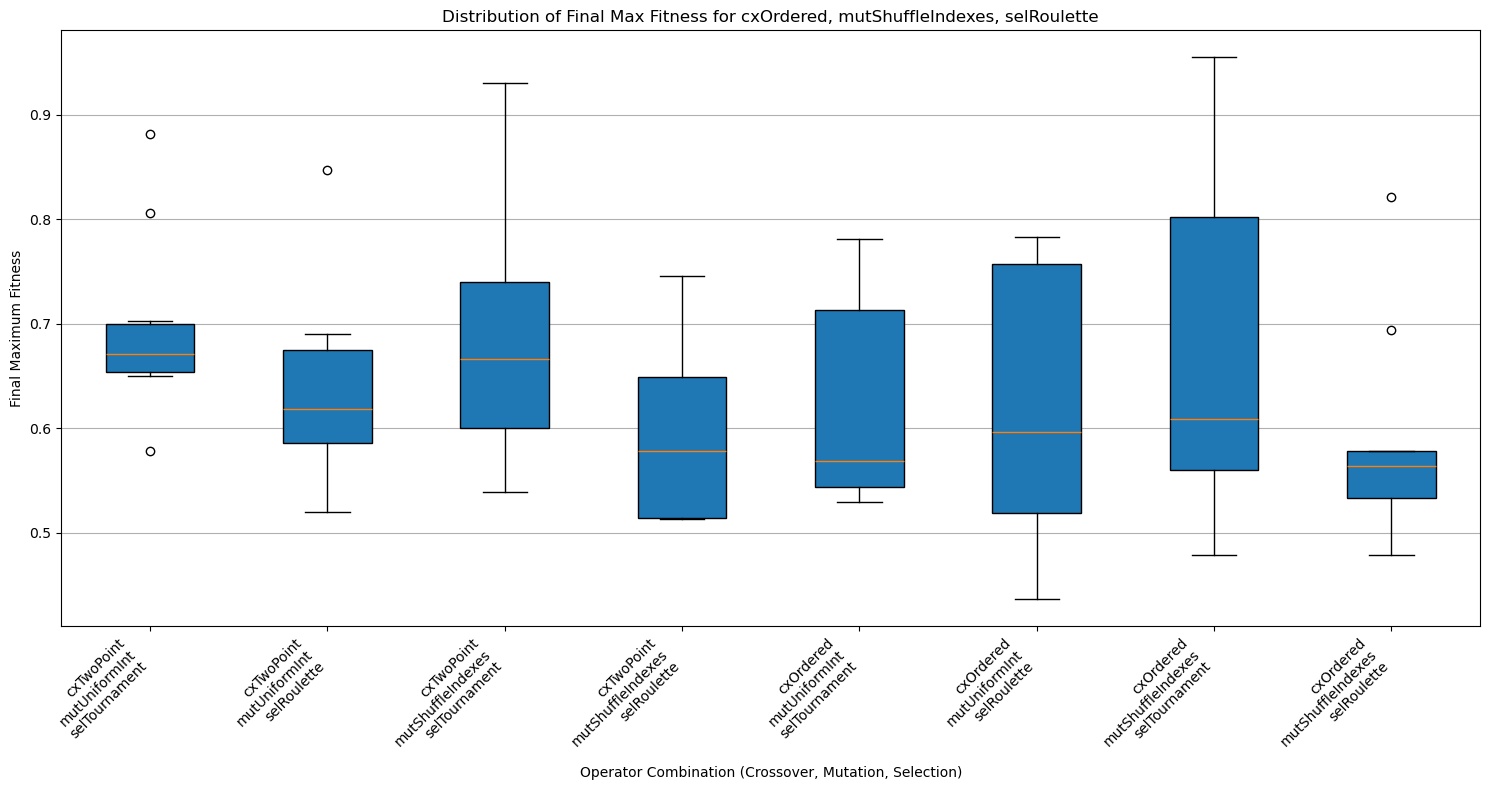

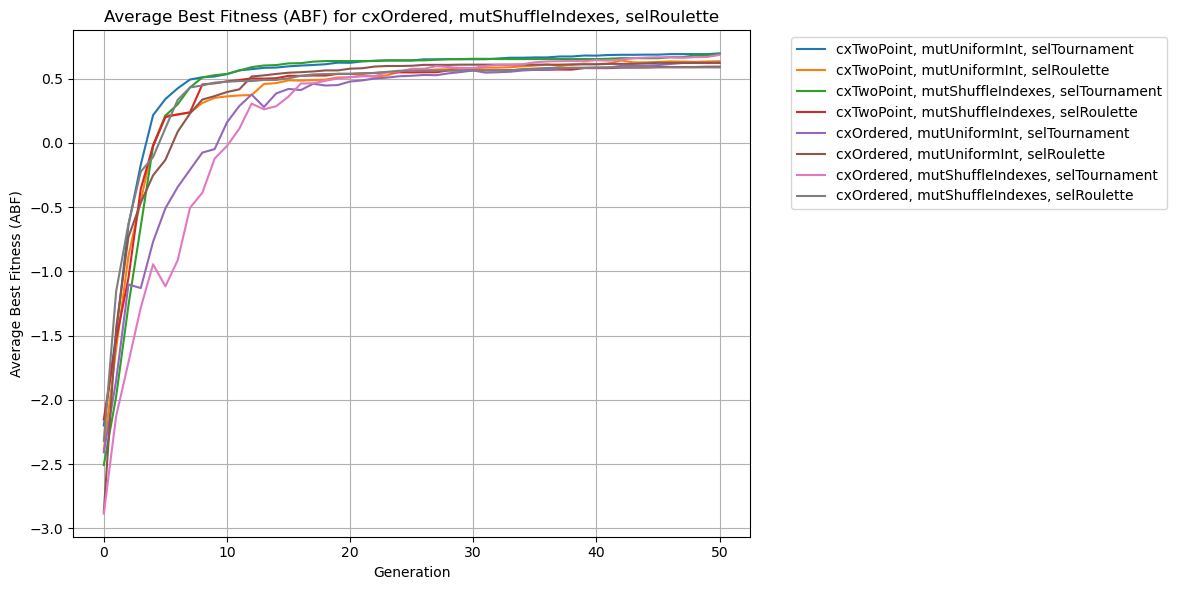

In [15]:
title = f"Distribution of Final Max Fitness for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
plot_boxplot(results, combinations, title)
title = f"Average Best Fitness (ABF) for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
plot_ABF(results, combinations, title)

# Q3

met een beetje hulp van AI

In [ ]:

NUM_RUNS = 10
NGEN = 50
POP_SIZE = 100


In [22]:
import copy

# 1) Refactor the runner:
def run_genetic_algorithm(toolbox, cxpb, mutpb, num_runs=NUM_RUNS):
    """
    Runs the GA num_runs times with the given crossover/mutation probabilities.
    Returns an array shape (n_generations, num_runs) of max fitness per gen/run.
    """
    max_fitnesses_all_runs = []

    for run in tqdm(range(num_runs), desc=f"GA Runs (cxpb={cxpb}, mutpb={mutpb})"):
        
        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(
            pop, toolbox,
            cxpb=cxpb,
            mutpb=mutpb,
            ngen=NGEN,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        # collect the max fitness at each generation
        max_fitnesses_all_runs.append(logbook.select("max"))

    # shape into (generations, runs)
    return np.array(max_fitnesses_all_runs).T


# 2) Build your probability‐combos list:
import itertools
crossover_prob_list = [0.2, 0.4, 0.6, 0.8]
mutation_prob_list  = [0.2, 0.4, 0.6, 0.8]
combinations_q3 = list(itertools.product(crossover_prob_list, mutation_prob_list))


# 3) Sweep over them, reusing your toolbox but with your *fixed* best operators:
best_crossover = tools.cxTwoPoint
best_mutation  = tools.mutUniformInt
best_selection = tools.selTournament

# Register toolbox
tbx = base.Toolbox()
tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))
tbx = register_specified_variant(tbx,best_crossover,best_mutation, best_selection)
results_q3 = {}
for i, (cxpb, mutpb) in enumerate(
        tqdm(combinations_q3, desc="Evaluating prob combinations")):

    # run and store
    max_fit = run_genetic_algorithm(tbx, cxpb, mutpb)
    results_q3[(cxpb, mutpb)] = max_fit


Evaluating prob combinations: 100%|██████████| 16/16 [5:44:48<00:00, 1293.06s/it]


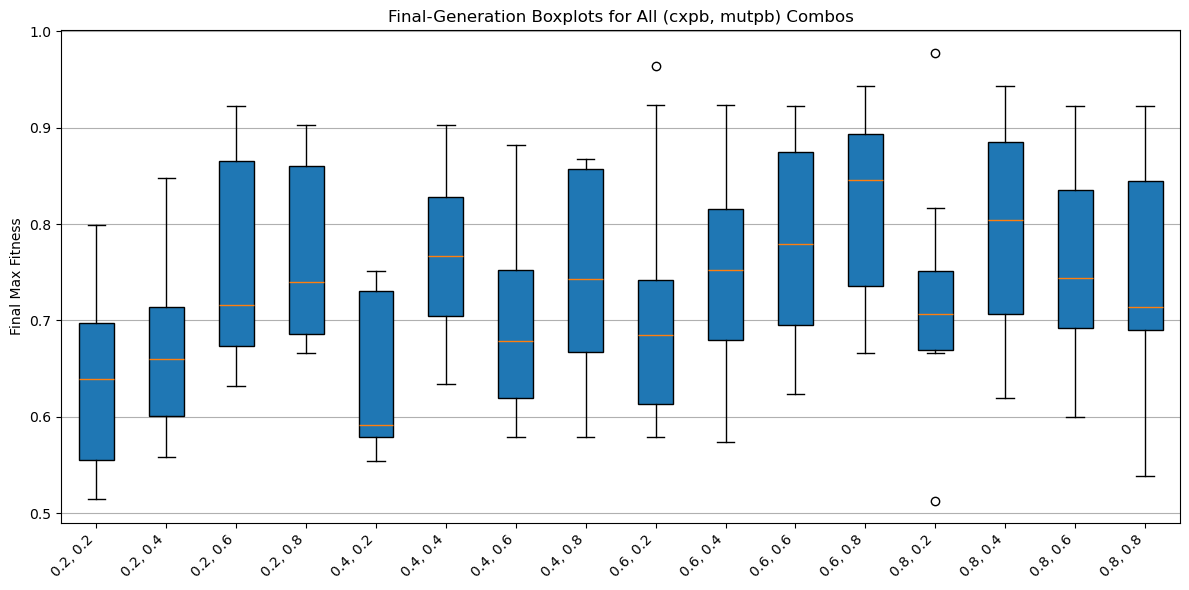

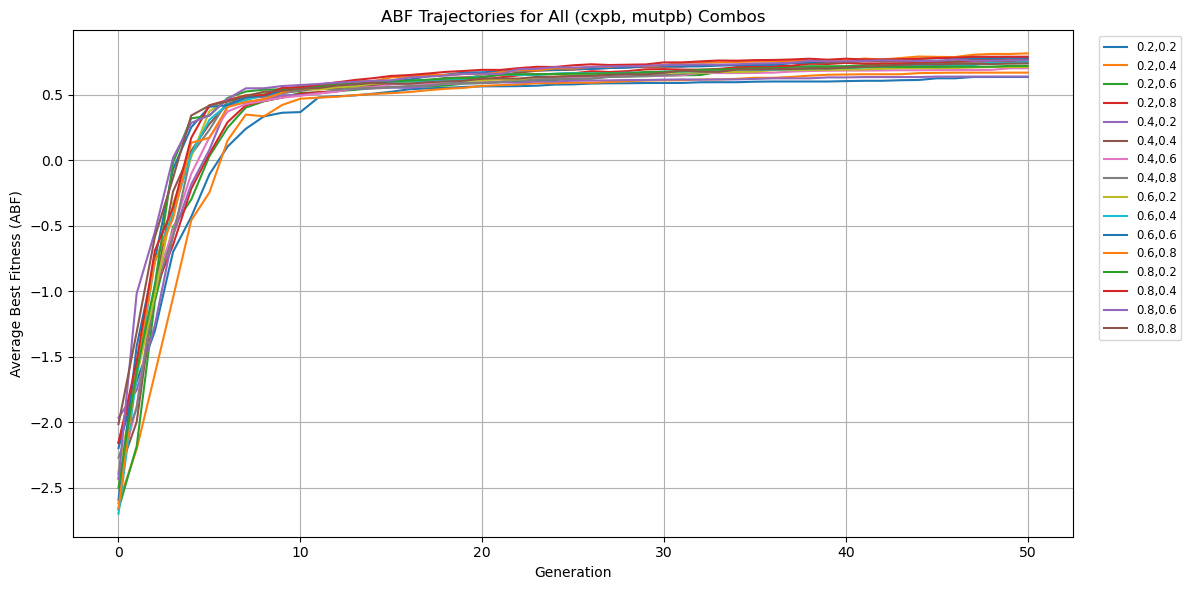

In [23]:
import matplotlib.pyplot as plt

# 1) Boxplots of the *final* generation for each (cxpb, mutpb)
fig, ax = plt.subplots(figsize=(12, 6))

labels = []
data_to_plot = []
for (cxpb, mutpb), arr in results_q3.items():
    # arr shape is (n_gens, n_runs); take the last row = final-gen fitnesses
    final_gen = arr[-1, :]
    data_to_plot.append(final_gen)
    labels.append(f"{cxpb:.1f}, {mutpb:.1f}")

ax.boxplot(data_to_plot, patch_artist=True)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel("Final Max Fitness")
ax.set_title("Final‐Generation Boxplots for All (cxpb, mutpb) Combos")
ax.grid(axis='y')
plt.tight_layout()
plt.show()


# 2) “Average Best Fitness” curves across generations for each combo
fig, ax = plt.subplots(figsize=(12, 6))

for (cxpb, mutpb), arr in results_q3.items():
    # compute ABF = mean over runs at each generation
    abf = arr.mean(axis=1)
    gens = range(len(abf))
    ax.plot(gens, abf, label=f"{cxpb:.1f},{mutpb:.1f}")

ax.set_xlabel("Generation")
ax.set_ylabel("Average Best Fitness (ABF)")
ax.set_title("ABF Trajectories for All (cxpb, mutpb) Combos")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
ax.grid()
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# 1) Gather the mean final‐generation fitness for each combo
records = []
for (cxpb, mutpb), arr in results_q3.items():
    # take the last generation (arr[-1,:]) and average over runs
    avg_best = arr[-1, :].mean()
    records.append({
        'mutation': mutpb,
        'crossover': cxpb,
        'avg_best_fitness': avg_best
    })

# 2) Build a DataFrame and pivot it into your desired grid
df = pd.DataFrame(records)
table = df.pivot(index='mutation',
                 columns='crossover',
                 values='avg_best_fitness')

# (Optional) give your axes nice names
table.index.name = 'mutation prob'
table.columns.name = 'crossover prob'

# 3) Display
print(table.round(4))


crossover prob     0.2     0.4     0.6     0.8
mutation prob                                 
0.2             0.6369  0.6402  0.7130  0.7216
0.4             0.6701  0.7732  0.7514  0.7917
0.6             0.7610  0.7034  0.7834  0.7644
0.8             0.7686  0.7492  0.8174  0.7405


# Q4

In [10]:
sol1= [[0, 1],[0, 2],[1, 3]]
sol2= [[8, 9],[11, 15],[15, 4]]

offspring = [sol1, sol2]
print(offspring)
print('-'*60)
for child in offspring:
    child[0][1] = 900

print(offspring)

[[[0, 1], [0, 2], [1, 3]], [[8, 9], [11, 15], [15, 4]]]
------------------------------------------------------------
[[[0, 900], [0, 2], [1, 3]], [[8, 900], [11, 15], [15, 4]]]


In [11]:
def checkSelfLoops():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            # Check for self-loops in the offspring
            for child in offspring:
                matrix = list_to_array(child)
                for i in range(len(matrix)): # [[0, 1], [2, 3], [1, 2], [2, 3]]
                    if matrix[i][0] == matrix[i][1]:
                        # If a self-loop is found, replace add or subtract 1
                        if matrix[i][0] == NR_TRANSITIONS - 1:
                            matrix[i][0] = matrix[i][0] - 1 
                        else:
                            matrix[i][1] = matrix[i][0] + 1
                child = matrix.flatten().tolist()
                # child[:] = matrix.flatten().tolist() 
            return offspring
        return wrapper
    return decorator

def checkBackwardsVisibleLoops():
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            # Check for backwards visible loops in the offspring
            for child in offspring:
                matrix = list_to_array(child)
                for i in range(len(matrix)): 
                    temp = matrix[i][0]
                    if matrix[i][0] > matrix[i][1]:
                        # If a backwards visible loop is found swap the values
                        matrix[i][0] = matrix[i][1]
                        matrix[i][1] = temp
                child = matrix.flatten().tolist()
                # child[:] = matrix.flatten().tolist() 
            return offspring
        return wrapper
    return decorator


In [12]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 50        # Number of Generations
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.8       # Crossover Probability
MUTPB = 0.4      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) # Uses fitness function from support to evaluate fitness
toolbox.register("mate", tools.cxTwoPoint) 
# toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB) # indpb is the probability of flipping each bit in the individual
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB) # low and up are the bounds for the mutation, indpb is the probability of mutation for each gene
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  # tournsize is the number of individuals to select for the tournament, fittest is selected for next gen

toolbox.decorate("mate", checkSelfLoops()) # Decorate the mate function to check for self-loops
toolbox.decorate("mate", checkBackwardsVisibleLoops()) # Decorate the mate function to check for backwards visible loops
toolbox.decorate("mutate", checkSelfLoops())
toolbox.decorate("mutate", checkBackwardsVisibleLoops())
toolbox.decorate("select", checkSelfLoops())
toolbox.decorate("select", checkBackwardsVisibleLoops())

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)



gen	nevals	max     	avg     	min	std   
0  	100   	-3.77262	-9.43265	-16	2.7331
1  	83    	-1.78456	-6.99572	-13	2.25495
2  	85    	-0.564754	-5.20803	-10	2.06896
3  	88    	-0.666535	-3.72588	-8 	1.79791
4  	88    	-0.441409	-2.73884	-8 	1.65865
5  	82    	0.558591 	-1.77296	-5.79957	1.19179
6  	91    	0.558591 	-1.34461	-5      	1.12175
7  	80    	0.596482 	-0.803756	-5      	1.01929
8  	96    	0.596482 	-0.487136	-3      	0.846194
9  	91    	0.596482 	-0.11531 	-3.47913	0.821928
10 	89    	0.596482 	0.211451 	-2.49766	0.571647
11 	90    	0.596482 	0.179093 	-4.58601	0.783671
12 	81    	0.596482 	0.106855 	-3.64894	0.8616  
13 	91    	0.596482 	0.187792 	-3.4521 	0.806113
14 	74    	0.596482 	0.23923  	-5      	0.893387
15 	91    	0.596482 	0.209747 	-5      	0.923564
16 	86    	0.596482 	0.346152 	-3.5011 	0.632513
17 	88    	0.596482 	0.268618 	-2.40808	0.67212 
18 	87    	0.615365 	0.457801 	-1.56001	0.438121
19 	96    	0.596482 	0.330161 	-2.71611	0.601342
20 	89    	0.596482 	0.

### Results Q4 for Q5 (using Tool Decorators)

In [13]:
best_ind = hof[0]
print("\nBest Individual:")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind) 
print("\nBest Matrix:")
print(best_matrix)


Best Individual:
[7, 6, 4, 3, 3, 7, 0, 3, 3, 6, 2, 4, 6, 8, 6, 8, 0, 3, 6, 8, 3, 7, 0, 2]
Fitness: 0.6342485847485843

Best Matrix:
[[7 6]
 [4 3]
 [3 7]
 [0 3]
 [3 6]
 [2 4]
 [6 8]
 [6 8]
 [0 3]
 [6 8]
 [3 7]
 [0 2]]


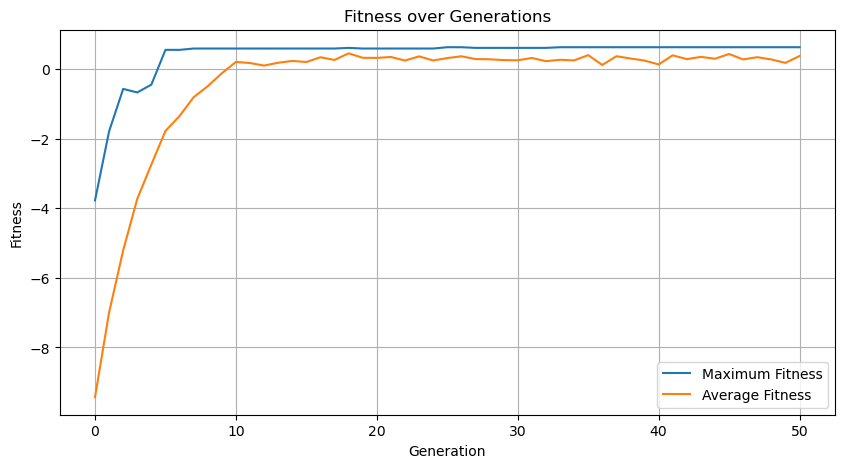

In [14]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness") 
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Visualize the best Petri net found
output_filename = "best_petri_net_decorator.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to best_petri_net_decorator.pdf


# Q5

### Results Q4 for Q5 (without Tool Decorators / equal to Q1 with optimal parameters from Q2/Q3)

In [16]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 50        # Number of Generations
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.8       # Crossover Probability
MUTPB = 0.4      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) # Uses fitness function from support to evaluate fitness
toolbox.register("mate", tools.cxTwoPoint) 
# toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB) # indpb is the probability of flipping each bit in the individual
# uniform integer mutation: each gene is reset to U(low,up) with probability indpb
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES-1, indpb=INDPB) # low and up are the bounds for the mutation, indpb is the probability of mutation for each gene
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  # tournsize is the number of individuals to select for the tournament, fittest is selected for next gen

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	max     	avg     	min	std   
0  	100   	-2.70324	-9.21619	-18	2.8537
1  	91    	-1.46438	-6.69636	-12	2.40428
2  	82    	0.319587	-4.46791	-10.8092	2.04498
3  	86    	0.341715	-2.93113	-6      	1.57159
4  	93    	0.480489	-2.01483	-7      	1.532  
5  	88    	0.538094	-1.06756	-5      	1.20325
6  	91    	0.538094	-0.396234	-5      	0.97338
7  	84    	0.538094	0.112888 	-2.56005	0.629758
8  	89    	0.538094	0.1986   	-2.51951	0.553924
9  	83    	0.538094	0.182921 	-2.65324	0.671204
10 	91    	0.538094	0.167117 	-2.40582	0.667569
11 	87    	0.538094	0.180585 	-2.83783	0.747531
12 	84    	0.538094	0.125724 	-3      	0.824588
13 	87    	0.538094	0.196743 	-4.67903	0.813305
14 	86    	0.538094	0.201567 	-3.54868	0.746956
15 	98    	0.538094	0.178178 	-3      	0.789471
16 	86    	0.538094	0.289087 	-3      	0.615132
17 	89    	0.538094	0.20757  	-2.6332 	0.685349
18 	88    	0.538094	0.243364 	-4      	0.807514
19 	83    	0.538094	0.174395 	-4.48491	0.804236
20 	90    	0.538094	0.32

In [17]:
best_ind = hof[0]
print("\nBest Individual:")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)


Best Individual:
[5, 6, 1, 5, 0, 6, 6, 8, 0, 3, 0, 2, 0, 3, 2, 6, 6, 7, 7, 8, 1, 7, 7, 8]
Fitness: 0.6191789321789318


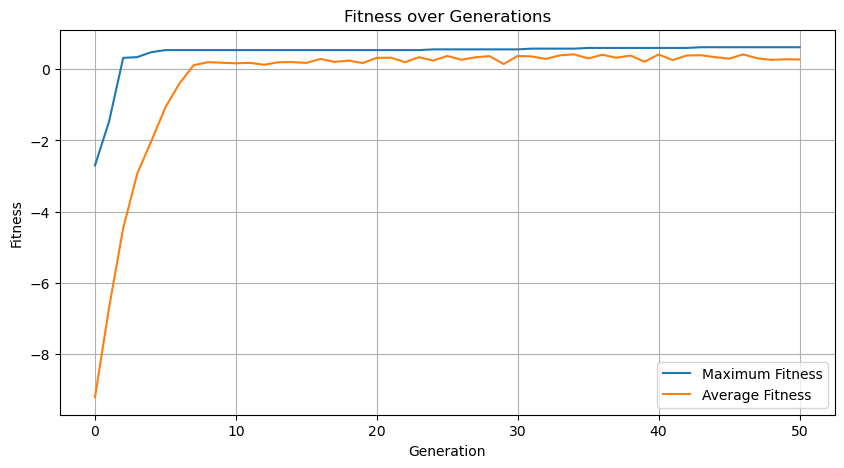

In [18]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Visualize the best Petri net found
output_filename = "best_petri_net_Q1_optimal_param.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to best_petri_net_Q1_optimal_param.pdf
